In [1]:
import sys
sys.path.append("..")
import os
import json
import seaborn as sns
from collections import Counter
import openai
import numpy as np
import pandas as pd
from explorer.utils import load_states_from_dir
from games.ultimatum.ultimatum_multi_turn.game import MultiTurnUltimatumGame
import itertools
from collections import defaultdict
import os
import json
import openai
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from explorer.utils import load_states_from_dir
import matplotlib.pyplot as plt
import warnings
import pandas as pd
from pandas.errors import SettingWithCopyWarning
import seaborn as sns
import matplotlib.pyplot as plt
colormap = sns.color_palette("Blues") 
warnings.simplefilter(action='ignore', category=(SettingWithCopyWarning))


2024-01-18 18:22:41.943 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager


In [2]:
%env OPENAI_API_KEY="g"

env: OPENAI_API_KEY="g"


In [3]:
def get_from_summary(key, game_state, default=None):
    if key in game_state.game_state[-1]['summary']:
        return game_state.game_state[-1]['summary'][key]
    else:
        return default

def replace_names(df):
    df_copy = df.copy()
    df_copy["model_1"] = df_copy["model_1"].replace(rename_dict)
    df_copy["model_2"] = df_copy["model_2"].replace(rename_dict)
    return df_copy
    
def from_pandas_to_aggregation(new_df):
    df_copy = new_df.copy()

    df_copy['models'] = df_copy['model_1'] + '@' + df_copy['model_2']
    df_copy['models'] = df_copy['models'].apply(lambda v: "@".join(sorted(v.split('@'))))
    
    # swap cells which are re-ordered
    to_swap = df_copy['model_1'].copy() > df_copy['model_2'].copy()
    temp = df_copy['resource_delta_1'][to_swap].copy()
    df_copy['resource_delta_1'][to_swap] = df_copy['resource_delta_2'][to_swap]
    df_copy['resource_delta_2'][to_swap] = temp.copy()
    
    df_copy['win_1'] = df_copy['resource_delta_1'] > df_copy['resource_delta_2']
    df_copy['win_2'] = df_copy['resource_delta_1'] < df_copy['resource_delta_2']
    df_copy['draw'] = df_copy['resource_delta_1'] == df_copy['resource_delta_2']
    
    df_copy = df_copy.groupby(['game_name', 'models'])[[ 'win_1', 'win_2', 'resource_delta_1', 'resource_delta_2']].agg(['mean',]).reset_index()
    
    df_copy[['model_1', 'model_2']] = df_copy['models'].str.split('@', n=1, expand=True)


    # is this wrong? i am trying to re-create the list of first vs second player
    
    win_rates = df_copy["win_1"]["mean"].tolist() + df_copy["win_2"]["mean"].tolist()
    payoffs = df_copy["resource_delta_1"]["mean"].tolist() + df_copy["resource_delta_2"]["mean"].tolist()
    
    
    model1 = df_copy["model_1"].tolist() + df_copy["model_2"].tolist()
    model2  = df_copy["model_2"].tolist() + df_copy["model_1"].tolist()
    
    aggregated = pd.DataFrame({"winrate" : win_rates, "payoff" : payoffs, "model_1" : model1, "model_2" : model2})
    return aggregated


def get_player_valuation(game_state, default=None):
    if "player_valuation" in game_state.game_state[0]["settings"]:
        vals = game_state.game_state[0]["settings"]["player_valuation"]
        return vals
    else:
        return default
        
def compute_game_summary(game_states):

    game_name = np.array([g.__class__.__name__ for g in game_states])[:, None]
    models = np.array([[ p.model for p in g.players] for g in game_states])
    outcomes = np.array([get_from_summary('player_outcome', g) for g in game_states])
    valuations = np.array([get_player_valuation(g, default=[None,None])  for g in game_states])
    initial_resources = np.array([get_from_summary('initial_resources', g) for g in game_states])
    final_resources = np.array([get_from_summary('final_resources', g) for g in game_states]),
    resources_delta = (final_resources-initial_resources)[0]

    original_valuations = valuations.reshape(-1, 2)
        
    resources_delta = np.array([v.value(r) if v else r.value() for r,v in zip(resources_delta.reshape(-1,), valuations.reshape(-1))])
    resources_delta = resources_delta.reshape(-1, 2)

    social_behavior = np.array([g.player_social_behaviour for g in game_states])
    social_behavior = social_behavior.reshape(-1, 2)
    
    
    df = np.concatenate((game_name, models, outcomes,  resources_delta, social_behavior, original_valuations), axis=1)
    df = pd.DataFrame(df, columns=['game_name','model_1','model_2','outcome_1','outcome_2', 'resource_delta_1', 'resource_delta_2', "social_1", "social_2", "vals1", "vals2"])

    return replace_names(df)


def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    return np.exp(x) / np.sum(np.exp(x), axis=0)


def normalize_win_rate(loc):
    "transform_win_rates_of_local_aggregate_into_probs_ingoring_draws"

    seen = set()

    l = loc.copy()
    
    for first in l.columns:
        for second in l.columns:
            if first!=second and first+second not in seen:
                one = l[first][second]
                two = l[second][first] 
    
                l[first][second], l[second][first] = one/(one+two), two/(one+two)

    return l
            

In [110]:
log_dir = "../experiments/additional_experiments/.logs/ultimatum_with_different_numbers/"
game_states = load_states_from_dir(log_dir) #+ load_states_from_dir(log_dir) 

AGENTS = ["gpt-4-1106-preview", "claude-2.1", "claude-2", "gpt-3.5-turbo-1106",]
AGENTS_CLEAN_NAMES = ["GPT-4", "Claude-2.1", "Claude-2", "GPT-3.5"]
rename_dict = {k:v for k,v in zip(AGENTS, AGENTS_CLEAN_NAMES)}


df = compute_game_summary(game_states)


Exception Type: AssertionError
Exception Message: WARNING : Game  ../experiments/additional_experiments/.logs/ultimatum_with_different_numbers/1705538690522/game_state.json has not ended

Stack Trace:
Traceback (most recent call last):
  File "/home/vinid/.local/lib/python3.10/site-packages/streamlit/runtime/caching/storage/in_memory_cache_storage_wrapper.py", line 87, in get
    entry_bytes = self._read_from_mem_cache(key)
  File "/home/vinid/.local/lib/python3.10/site-packages/streamlit/runtime/caching/storage/in_memory_cache_storage_wrapper.py", line 137, in _read_from_mem_cache
    raise CacheStorageKeyNotFoundError("Key not found in mem cache")
streamlit.runtime.caching.storage.cache_storage_protocol.CacheStorageKeyNotFoundError: Key not found in mem cache

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/vinid/.local/lib/python3.10/site-packages/streamlit/runtime/caching/cache_data_api.py", line 596, in read_re

In [111]:
df["total_sum"] = df.apply(lambda x: x.outcome_1.resource_dict["Dollars"]+x.outcome_2.resource_dict["Dollars"],axis=1)
df = df[df["resource_delta_2"] != 0]

In [112]:
df["resource_delta_1"] = df["resource_delta_1"] + df["total_sum"]

In [113]:
df["resource_delta_1"] = (df["resource_delta_1"]/df["total_sum"]).apply(lambda x : round(x, 4))

In [114]:
df["resource_delta_2"] = (df["resource_delta_2"]/df["total_sum"]).apply(lambda x : round(x, 4))

In [115]:
mini_df = df.groupby("total_sum")[['resource_delta_1', 'resource_delta_2']].mean()

In [116]:
df

,game_name,model_1,model_2,outcome_1,outcome_2,resource_delta_1,resource_delta_2,social_1,social_2,vals1,vals2,total_sum
0,MultiTurnUltimatumGame,GPT-4,GPT-4,Dollars: 17,Dollars: 10,0.6296,0.3704,,,None,None,27
1,MultiTurnUltimatumGame,GPT-4,GPT-4,Dollars: 22,Dollars: 5,0.8148,0.1852,,,None,None,27
2,MultiTurnUltimatumGame,GPT-4,GPT-4,Dollars: 17,Dollars: 10,0.6296,0.3704,,,None,None,27
3,MultiTurnUltimatumGame,GPT-4,GPT-4,Dollars: 22,Dollars: 5,0.8148,0.1852,,,None,None,27
4,MultiTurnUltimatumGame,GPT-4,GPT-4,Dollars: 17,Dollars: 10,0.6296,0.3704,,,None,None,27
...,...,...,...,...,...,...,...,...,...,...,...,...
415,MultiTurnUltimatumGame,GPT-4,GPT-4,Dollars: 6000000000,Dollars: 4000000000,0.6000,0.4000,,,None,None,10000000000
416,MultiTurnUltimatumGame,GPT-4,GPT-4,Dollars: 6000000000,Dollars: 4000000000,0.6000,0.4000,,,None,None,10000000000
417,MultiTurnUltimatumGame,GPT-4,GPT-4,Dollars: 8000000000,Dollars: 2000000000,0.8000,0.2000,,,None,None,10000000000
418,MultiTurnUltimatumGame,GPT-4,GPT-4,Dollars: 8000000000,Dollars: 2000000000,0.8000,0.2000,,,None,None,10000000000


In [117]:
scatter_df = df[df.total_sum.isin([100, 1000, 10000, 1000000, 100000000, 10000000000])]

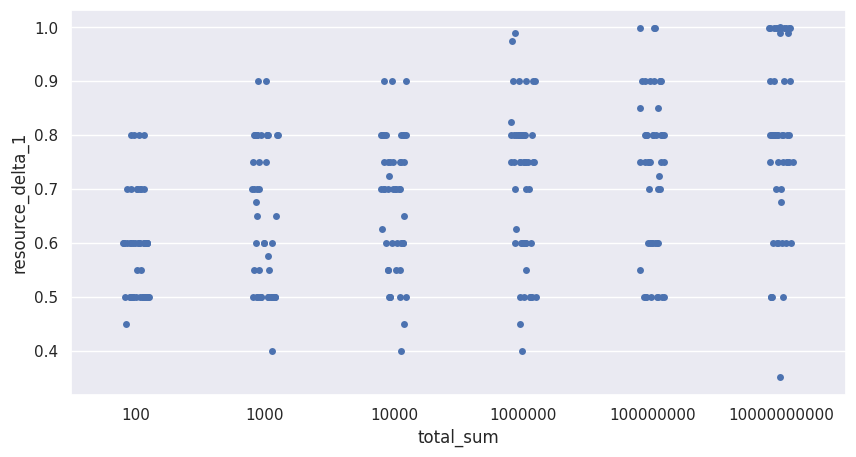

In [118]:
import seaborn as sns

sns.set(rc = {'figure.figsize':(10, 5)})  # (width_inches, width_height)
ax = sns.stripplot(scatter_df, x="total_sum", y="resource_delta_1")


In [119]:
scatter_df["total_sum"].values

array([        100,         100,         100,         100,         100,
               100,         100,         100,         100,         100,
               100,         100,         100,         100,         100,
               100,         100,         100,         100,         100,
              1000,        1000,        1000,        1000,        1000,
              1000,        1000,        1000,        1000,        1000,
              1000,        1000,        1000,        1000,        1000,
              1000,        1000,        1000,        1000,        1000,
             10000,       10000,       10000,       10000,       10000,
             10000,       10000,       10000,       10000,       10000,
             10000,       10000,       10000,       10000,       10000,
             10000,       10000,       10000,       10000,       10000,
           1000000,     1000000,     1000000,     1000000,     1000000,
           1000000,     1000000,     1000000,     1000000,     1

In [120]:
df.groupby("total_sum")[['resource_delta_1', 'resource_delta_2']]

In [121]:
mini_df = mini_df[mini_df.index.isin([100, 1000, 10000, 1000000, 100000000, 10000000000])]

<AxesSubplot:xlabel='total_sum'>

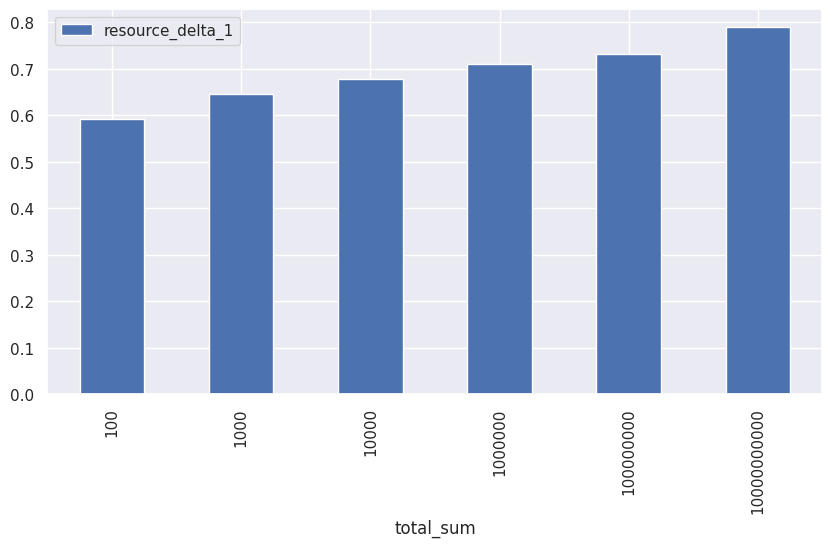

In [122]:
mini_df.reset_index().plot.bar(x='total_sum', y='resource_delta_1')

In [49]:
mini_df.index

Index([100, 1000, 10000, 1000000, 100000000], dtype='int64', name='total_sum')